In [3]:
import pandas as pd
from pandas_datareader import data as web   # Package and modules for importing data; this code may change depending on pandas version
import datetime

In [4]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

In [5]:
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = web.DataReader("AAPL", "yahoo", start, end)
 
type(apple)

pandas.core.frame.DataFrame

In [6]:
apple.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,67649400,102.612183
2016-01-05,105.750000,105.849998,102.410004,102.709999,55791000,100.040792
2016-01-06,100.559998,102.370003,99.870003,100.699997,68457400,98.083025
2016-01-07,98.680000,100.129997,96.430000,96.449997,81094400,93.943473
2016-01-08,98.550003,99.110001,96.760002,96.959999,70798000,94.440222


Populating the interactive namespace from numpy and matplotlib


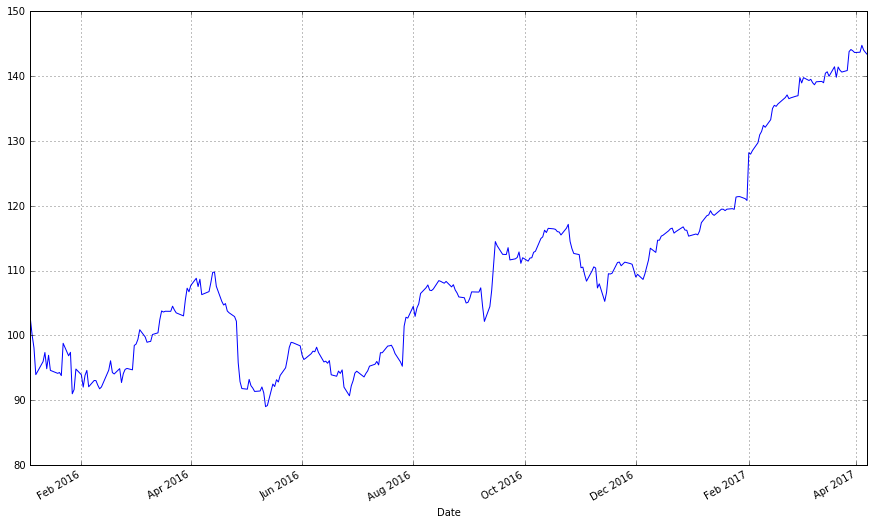

In [7]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

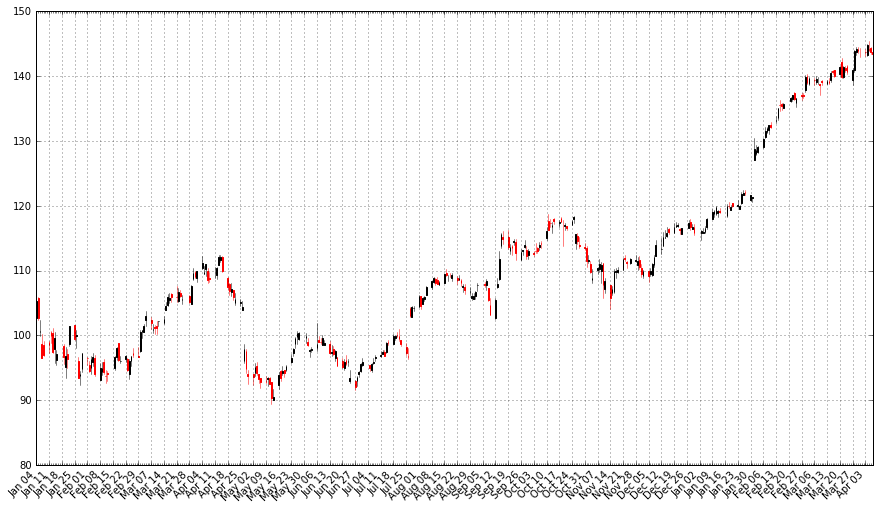

In [8]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

In [9]:
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,102.612183,741.840027,53.015032
2016-01-05,100.040792,742.580017,53.256889
2016-01-06,98.083025,743.619995,52.289462
2016-01-07,93.943473,726.390015,50.470697
2016-01-08,94.440222,714.469971,50.625489


In [10]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,1.000000,1.000000,1.000000
2016-01-05,0.974941,1.000998,1.004562
2016-01-06,0.955861,1.002399,0.986314
2016-01-07,0.915520,0.979173,0.952007
2016-01-08,0.920361,0.963105,0.954927


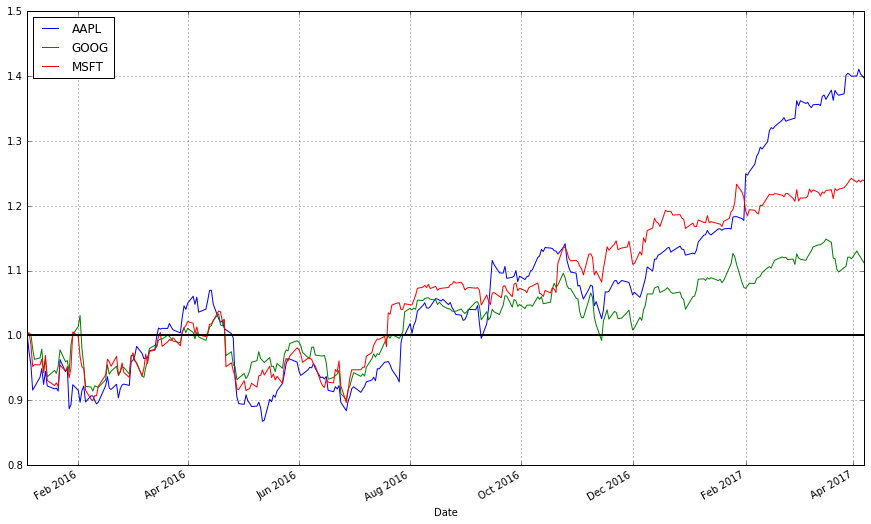

In [11]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [12]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()


,AAPL,GOOG,MSFT
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025379,0.000997,0.004552
2016-01-06,-0.019764,0.001400,-0.018332
2016-01-07,-0.043121,-0.023443,-0.035402
2016-01-08,0.005274,-0.016546,0.003062


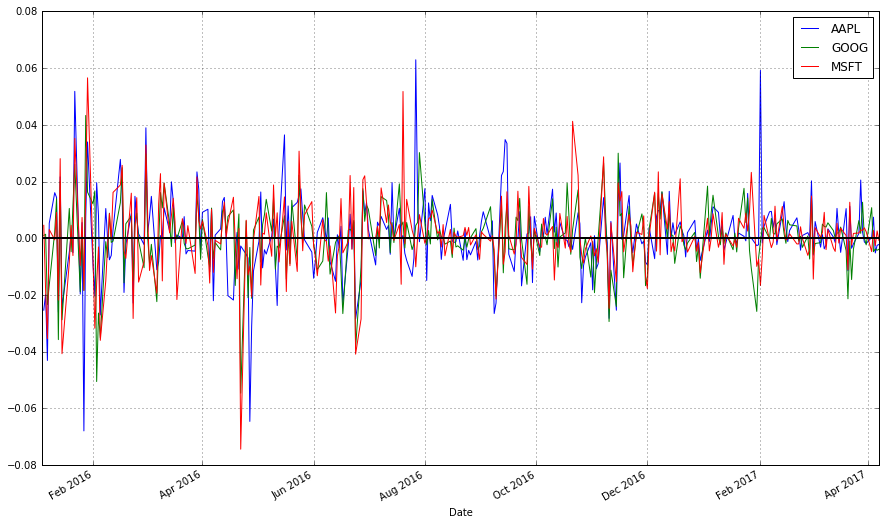

In [13]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

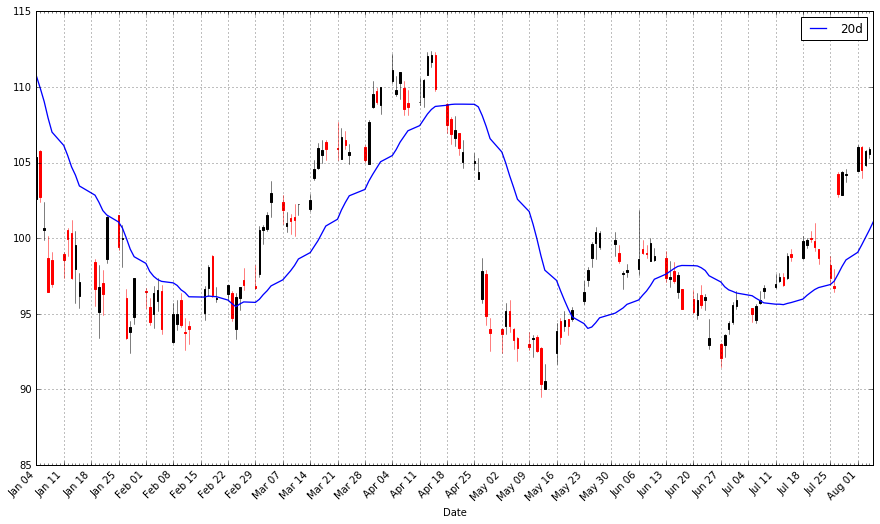

In [16]:
start = datetime.datetime(2010,1,1)
apple = web.DataReader("AAPL", "yahoo", start, end)

apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

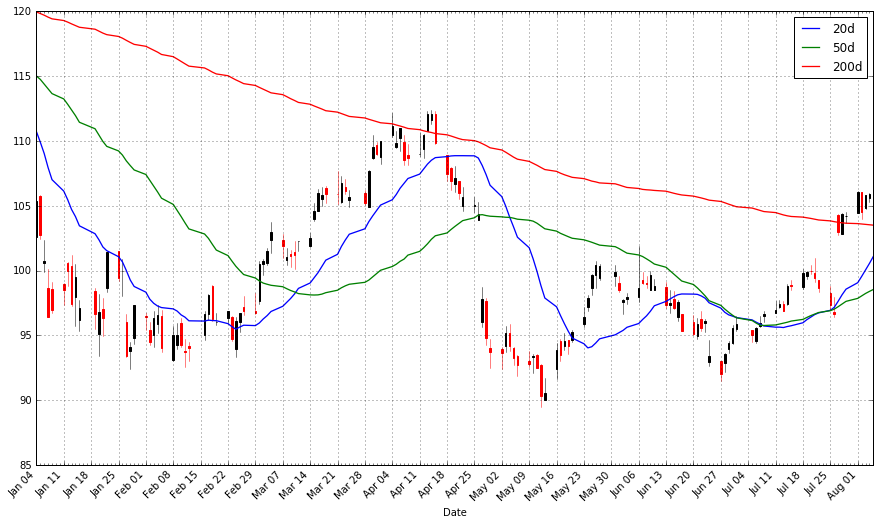

In [17]:
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = ["20d", "50d", "200d"])

In [18]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2017-04-03,143.710007,144.119995,143.050003,143.699997,19985700,143.699997,141.00,135.35,115.88,5.65
2017-04-04,143.250000,144.889999,143.169998,144.770004,19765700,144.770004,141.26,135.84,116.13,5.42
2017-04-05,144.220001,145.460007,143.809998,144.020004,27481500,144.020004,141.52,136.32,116.37,5.20
2017-04-06,144.289993,144.520004,143.449997,143.660004,21118000,143.660004,141.76,136.76,116.61,5.00
2017-04-07,143.729996,144.179993,143.270004,143.339996,16621300,143.339996,141.97,137.18,116.85,4.79


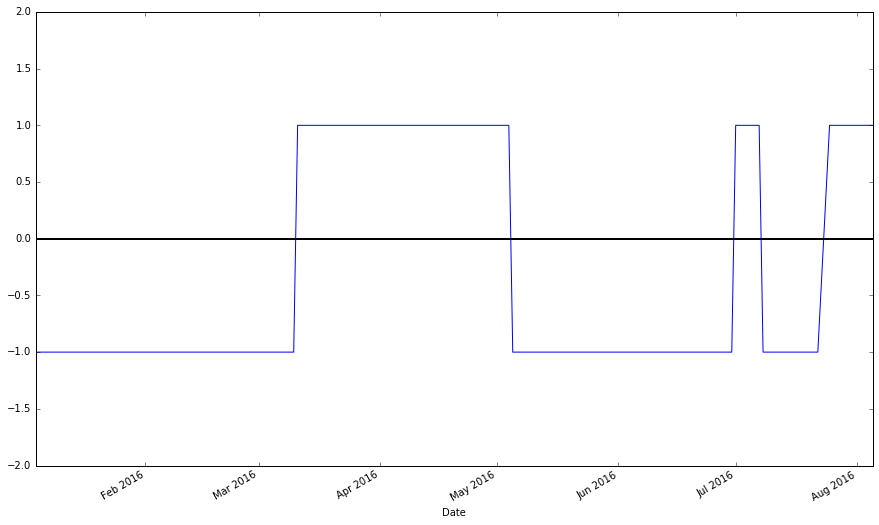

In [19]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-01':'2016-08-07',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

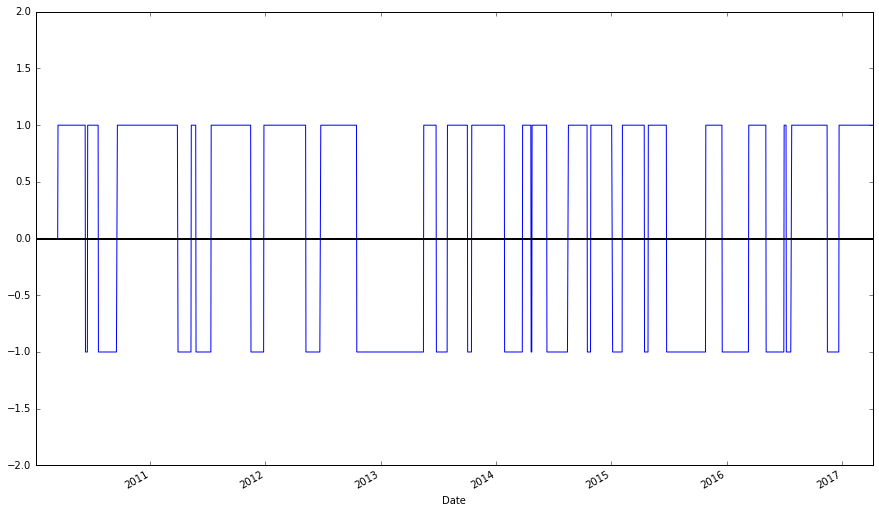

In [20]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [21]:
apple["Regime"].value_counts()

 1    1090
-1     689
 0      50
Name: Regime, dtype: int64

In [22]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2017-04-03,143.710007,144.119995,143.050003,143.699997,19985700,143.699997,141.00,135.35,115.88,5.65,1.0,0.0
2017-04-04,143.250000,144.889999,143.169998,144.770004,19765700,144.770004,141.26,135.84,116.13,5.42,1.0,0.0
2017-04-05,144.220001,145.460007,143.809998,144.020004,27481500,144.020004,141.52,136.32,116.37,5.20,1.0,0.0
2017-04-06,144.289993,144.520004,143.449997,143.660004,21118000,143.660004,141.76,136.76,116.61,5.00,1.0,0.0
2017-04-07,143.729996,144.179993,143.270004,143.339996,16621300,143.339996,141.97,137.18,116.85,4.79,1.0,-1.0


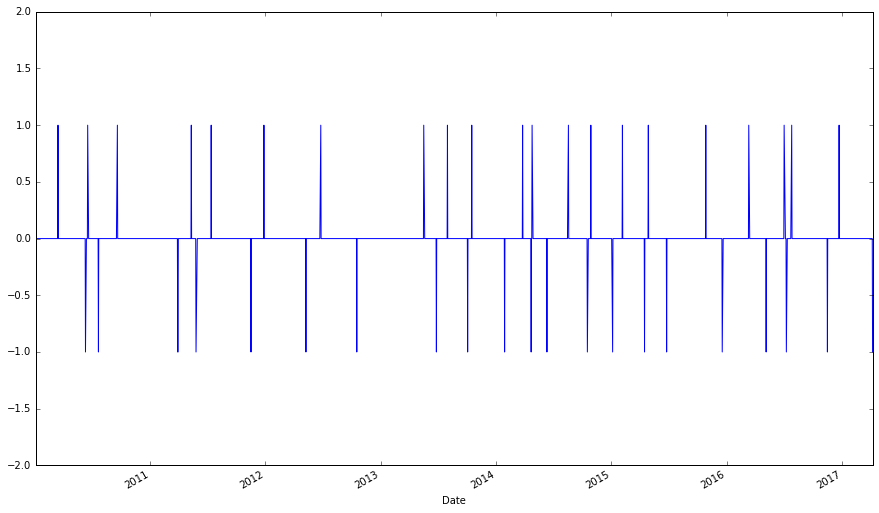

In [23]:
apple["Signal"].plot(ylim = (-2, 2))

In [24]:
apple.loc[apple["Signal"] == 1, "Close"]

Date
2010-03-16    224.449997
2010-06-18    274.070011
2010-09-20    283.230007
2011-05-12    346.569988
2011-07-14    357.770004
2011-12-28    402.640003
2012-06-25    570.770020
2013-05-17    433.260010
2013-07-31    452.529984
2013-10-16    501.110001
2014-03-26    539.779991
2014-04-25    571.939980
2014-08-18     99.160004
2014-10-28    106.739998
2015-02-05    119.940002
2015-04-28    130.559998
2015-10-27    114.550003
2016-03-11    102.260002
2016-07-01     95.889999
2016-07-25     97.339996
2016-12-22    116.290001
Name: Close, dtype: float64

In [25]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-16,224.449997,1.0,Buy
2010-06-11,253.509995,-1.0,Sell
2010-06-18,274.070011,1.0,Buy
2010-07-22,259.020000,-1.0,Sell
2010-09-20,283.230007,1.0,Buy
2011-03-30,348.630009,0.0,Sell
2011-03-31,348.510006,-1.0,Sell
2011-05-12,346.569988,1.0,Buy
2011-05-27,337.409992,-1.0,Sell


In [26]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2010-03-16,2010-06-11,224.449997,29.059998
2010-06-18,2010-07-22,274.070011,-15.050011
2010-09-20,2011-03-30,283.230007,65.400002
2011-05-12,2011-05-27,346.569988,-9.159996
2011-07-14,2011-11-17,357.770004,19.639996
2011-12-28,2012-05-09,402.640003,166.540020
2012-06-25,2012-10-17,570.770020,73.839981
2013-05-17,2013-06-26,433.260010,-35.190018
2013-07-31,2013-10-03,452.529984,30.880012


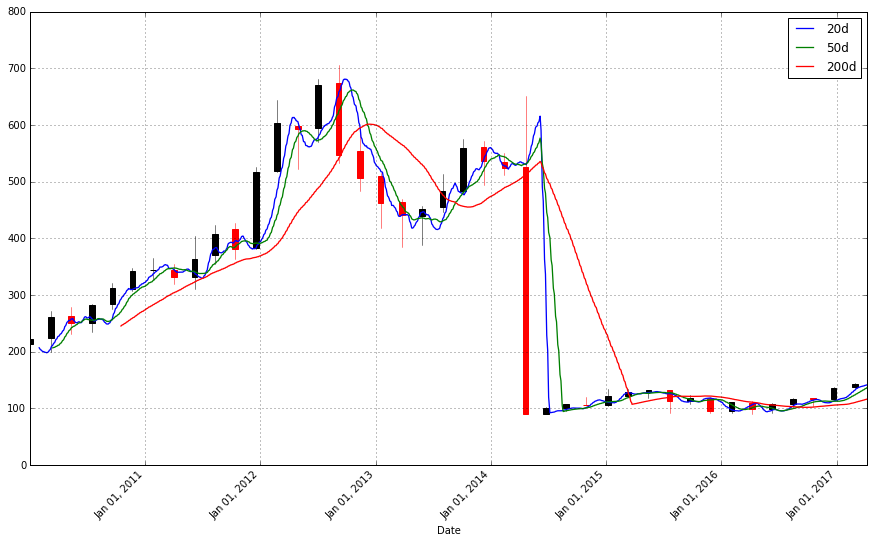

In [27]:
# Let's see the result over the whole period for which we have Apple data
pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d", "200d"])

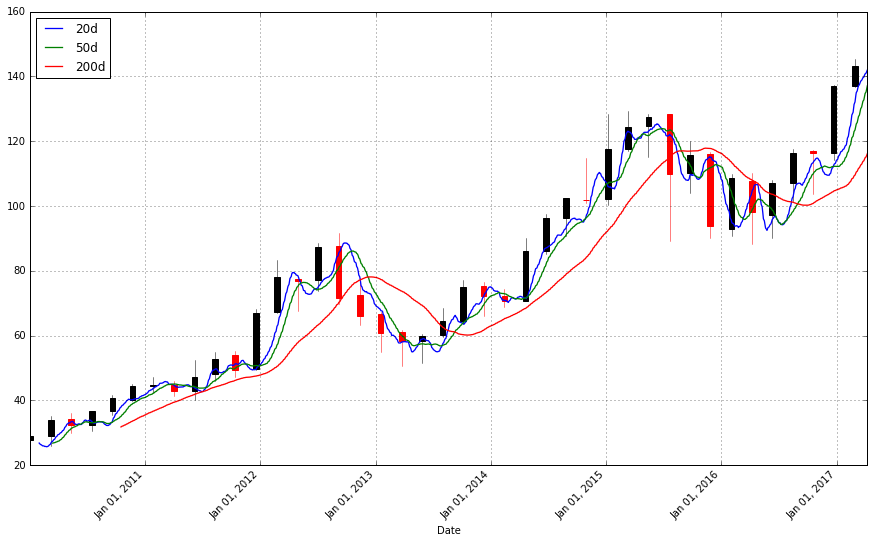

In [28]:
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})
 
apple_adj = ohlc_adj(apple)
 
# This next code repeats all the earlier analysis we did on the adjusted data
 
apple_adj["20d"] = np.round(apple_adj["Close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["Close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["Close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
# Restore original regime data
apple_adj.ix[-1, "Regime"] = regime_orig
 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_adj_signals.sort_index(inplace = True)
apple_adj_long_profits = pd.DataFrame({
        "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })
 
pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])

In [29]:
apple_adj_long_profits

,End Date,Price,Profit
Date,,,
2010-03-16,2010-06-10,29.079641,3.376323
2010-06-18,2010-07-21,35.508388,-2.569168
2010-09-20,2011-03-30,36.695153,8.473194
2011-05-12,2011-05-27,44.901452,-1.186765
2011-07-14,2011-11-17,46.352521,2.544549
2011-12-28,2012-05-09,52.165858,21.576850
2012-06-25,2012-10-17,73.948707,9.925249
2013-05-17,2013-06-26,57.338536,-4.657121
2013-07-31,2013-10-04,59.888765,4.458515


In [30]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_adj_long_profits.index,
                            "End": apple_adj_long_profits["End Date"]})
apple_adj_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple_adj.loc[x["Start"]:x["End"], "Low"]), axis = 1)
apple_adj_long_profits

,End Date,Price,Profit,Low
Date,,,,
2010-03-16,2010-06-10,29.079641,3.376323,25.814740
2010-06-18,2010-07-21,35.508388,-2.569168,31.042470
2010-09-20,2011-03-30,36.695153,8.473194,35.628875
2011-05-12,2011-05-27,44.901452,-1.186765,42.679509
2011-07-14,2011-11-17,46.352521,2.544549,45.737111
2011-12-28,2012-05-09,52.165858,21.576850,51.889895
2012-06-25,2012-10-17,73.948707,9.925249,73.280179
2013-05-17,2013-06-26,57.338536,-4.657121,52.362472
2013-07-31,2013-10-04,59.888765,4.458515,59.478506


In [31]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_adj_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2010-03-16,2010-06-10,1.011479e+06,3.376323,29.079641,3400.0,1.000000e+06,0.0,11479.4982,98870.7794
2010-06-18,2010-07-21,1.004286e+06,-2.569168,35.508388,2800.0,1.011479e+06,0.0,-7193.6704,99423.4864
2010-09-20,2011-03-30,1.027163e+06,8.473194,36.695153,2700.0,1.004286e+06,0.0,22877.6238,99076.9131
2011-05-12,2011-05-27,1.024553e+06,-1.186765,44.901452,2200.0,1.027163e+06,0.0,-2610.8830,98783.1944
2011-07-14,2011-11-17,1.030151e+06,2.544549,46.352521,2200.0,1.024553e+06,0.0,5598.0078,101975.5462
2011-12-28,2012-05-09,1.071147e+06,21.576850,52.165858,1900.0,1.030151e+06,0.0,40996.0150,99115.1302
2012-06-25,2012-10-17,1.085042e+06,9.925249,73.948707,1400.0,1.071147e+06,0.0,13895.3486,103528.1898
2013-05-17,2013-06-26,1.076659e+06,-4.657121,57.338536,1800.0,1.085042e+06,0.0,-8382.8178,103209.3648
2013-07-31,2013-10-04,1.084239e+06,4.458515,59.888765,1700.0,1.076659e+06,0.0,7579.4755,101810.9005
2013-10-16,2014-01-28,1.086018e+06,1.111968,66.755822,1600.0,1.084239e+06,0.0,1779.1488,106809.3152


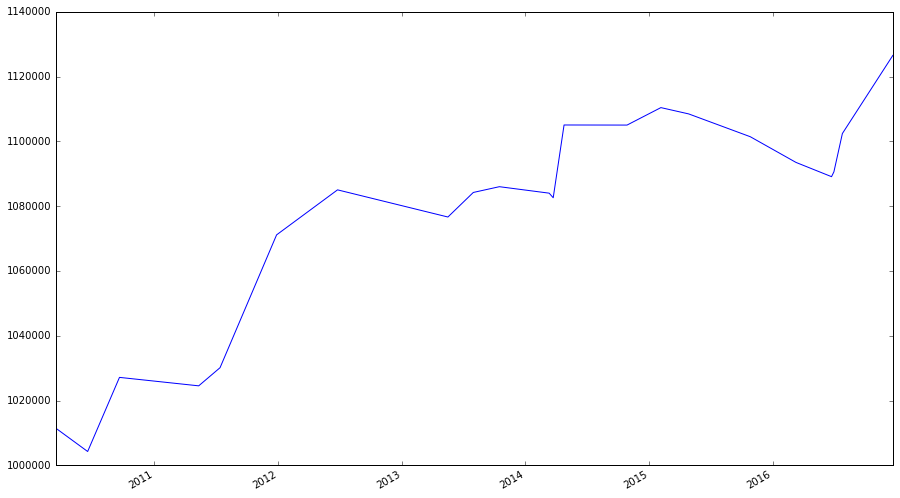

In [32]:
apple_backtest["End Port. Value"].plot()

In [33]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
 
    :return: pandas DataFrame containing stock orders
 
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].ix[-1, "Regime"]
        s[1].ix[-1, "Regime"] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].ix[-1, "Regime"] = regime_orig
 
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 
 
def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
 
    :return: pandas DataFrame with backtesting results
 
    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
 
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
 
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared
 
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
 
        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
 
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results
 
# Get more stocks
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
facebook = web.DataReader("FB", "yahoo", start, end)
twitter = web.DataReader("TWTR", "yahoo", start, end)
netflix = web.DataReader("NFLX", "yahoo", start, end)
amazon = web.DataReader("AMZN", "yahoo", start, end)
yahoo = web.DataReader("YHOO", "yahoo", start, end)
sony = web.DataReader("SNY", "yahoo", start, end)
nintendo = web.DataReader("NTDOY", "yahoo", start, end)
ibm = web.DataReader("IBM", "yahoo", start, end)
hp = web.DataReader("HPQ", "yahoo", start, end)

In [34]:
signals = ma_crossover_orders([("AAPL", ohlc_adj(apple)),
                              ("MSFT",  ohlc_adj(microsoft)),
                              ("GOOG",  ohlc_adj(google)),
                              ("FB",    ohlc_adj(facebook)),
                              ("TWTR",  ohlc_adj(twitter)),
                              ("NFLX",  ohlc_adj(netflix)),
                              ("AMZN",  ohlc_adj(amazon)),
                              ("YHOO",  ohlc_adj(yahoo)),
                              ("SNY",   ohlc_adj(yahoo)),
                              ("NTDOY", ohlc_adj(nintendo)),
                              ("IBM",   ohlc_adj(ibm)),
                              ("HPQ",   ohlc_adj(hp))],
                            fast = 20, slow = 50)
signals

Price  Regime Signal
Date       Symbol                           
2010-03-16 AAPL     29.079641     1.0    Buy
           AMZN    131.789993     1.0    Buy
           GOOG    282.318173    -1.0   Sell
           HPQ      20.210448     1.0    Buy
           IBM     108.709663     1.0    Buy
           MSFT     24.364279    -1.0   Sell
           NFLX     10.090000     1.0    Buy
           NTDOY    37.099998     1.0    Buy
           SNY      16.360001    -1.0   Sell
           YHOO     16.360001    -1.0   Sell
2010-03-17 SNY      16.500000     1.0    Buy
           YHOO     16.500000     1.0    Buy
2010-03-22 GOOG    278.472004     1.0    Buy
2010-03-23 MSFT     24.787355     1.0    Buy
2010-05-03 GOOG    265.035411    -1.0   Sell
2010-05-10 HPQ      18.955740    -1.0   Sell
2010-05-14 NTDOY    35.799999    -1.0   Sell
2010-05-17 SNY      16.270000    -1.0   Sell
           YHOO     16.270000    -1.0   Sell
2010-05-19 AMZN    124.589996    -1.0   Sell
           MSFT     23.532582    -1.0   Sell
2010-05-21 IBM     106.506978    -1.0   Sell
2010-06-10 AAPL     32.455964     0.0   Sell
2010-06-11 AAPL     32.844641    -1.0   Sell
2010-06-18 AAPL     35.508388     1.0    Buy
2010-06-28 IBM     109.530137     1.0    Buy
2010-07-01 IBM     104.086752    -1.0   Sell
2010-07-06 IBM     104.842542     1.0    Buy
2010-07-09 NTDOY    36.950001     1.0    Buy
2010-07-20 IBM     107.466581    -1.0   Sell
...                       ...     ...    ...
2016-11-18 HPQ      15.615612     1.0    Buy
           IBM     159.131761     1.0    Buy
2016-12-12 NTDOY    32.090000     1.0    Buy
           TWTR     18.930000     1.0    Buy
2016-12-21 AAPL    116.554665     1.0    Buy
           NTDOY    25.730000    -1.0   Sell
2016-12-23 GOOG    789.909973     1.0    Buy
2016-12-29 TWTR     16.389999    -1.0   Sell
2017-01-09 AMZN    796.919983     1.0    Buy
2017-01-10 HPQ      14.577391    -1.0   Sell
2017-01-12 FB      126.620003     1.0    Buy
2017-01-20 SNY      42.049999     1.0    Buy
           YHOO     42.049999     1.0    Buy
2017-02-14 HPQ      15.936888     0.0    Buy
2017-02-15 HPQ      15.857502     1.0    Buy
2017-03-09 NTDOY    26.860001     0.0    Buy
2017-03-10 NTDOY    26.850000     1.0    Buy
2017-03-30 IBM     173.860001    -1.0   Sell
2017-04-07 AAPL    143.339996     1.0   Sell
           AMZN    894.880005     1.0   Sell
           FB      140.779999     1.0   Sell
           GOOG    824.669983     1.0   Sell
           HPQ      17.370001     1.0   Sell
           IBM     172.139999    -1.0    Buy
           MSFT     65.680000     1.0   Sell
           NFLX    143.110001     1.0   Sell
           NTDOY    29.160000     1.0   Sell
           SNY      46.439999     1.0   Sell
           TWTR     14.290000    -1.0    Buy
           YHOO     46.439999     1.0   Sell

[513 rows x 3 columns]

In [35]:
bk = backtest(signals, 1000000)
bk

End Cash  Portfolio Value  Profit per Share  \
Date       Symbol                                                    
2010-03-16 AAPL    9.011292e+05     1.000000e+06          0.000000   
           AMZN    8.088762e+05     1.000000e+06          0.000000   
           GOOG    8.088762e+05     1.000000e+06          0.000000   
           HPQ     7.098450e+05     1.000000e+06          0.000000   
           IBM     6.120063e+05     1.000000e+06          0.000000   
           MSFT    6.120063e+05     1.000000e+06          0.000000   
           NFLX    5.121153e+05     1.000000e+06          0.000000   
           NTDOY   4.156553e+05     1.000000e+06          0.000000   
           SNY     4.156553e+05     1.000000e+06          0.000000   
           YHOO    4.156553e+05     1.000000e+06          0.000000   
2010-03-17 SNY     3.166553e+05     1.000000e+06          0.000000   
           YHOO    2.176553e+05     1.000000e+06          0.000000   
2010-03-22 GOOG    1.341137e+05     1.000000e+06          0.000000   
2010-03-23 MSFT    3.496432e+04     1.000000e+06          0.000000   
2010-05-03 GOOG    1.144749e+05     9.959690e+05        -13.436593   
2010-05-10 HPQ     2.073581e+05     9.898210e+05         -1.254708   
2010-05-14 NTDOY   3.004381e+05     9.864410e+05         -1.299999   
2010-05-17 SNY     3.980581e+05     9.850610e+05         -0.230000   
           YHOO    4.956781e+05     9.836810e+05         -0.230000   
2010-05-19 AMZN    5.828911e+05     9.786410e+05         -7.199997   
           MSFT    6.770214e+05     9.736219e+05         -1.254773   
2010-05-21 IBM     7.728777e+05     9.716394e+05         -2.202685   
2010-06-10 AAPL    8.832279e+05     9.831189e+05          3.376323   
2010-06-11 AAPL    8.832279e+05     9.831189e+05          3.765000   
2010-06-18 AAPL    7.873553e+05     9.831189e+05          0.000000   
2010-06-28 IBM     6.997312e+05     9.831189e+05          0.000000   
2010-07-01 IBM     7.830006e+05     9.787642e+05         -5.443385   
2010-07-06 IBM     6.886423e+05     9.787642e+05          0.000000   
2010-07-09 NTDOY   5.925723e+05     9.787642e+05          0.000000   
2010-07-20 IBM     6.892922e+05     9.811259e+05          2.624039   
...                         ...              ...               ...   
2016-11-18 HPQ     1.475180e+06     2.056827e+06          0.000000   
           IBM     1.284222e+06     2.056827e+06          0.000000   
2016-12-12 NTDOY   1.078846e+06     2.056827e+06          0.000000   
           TWTR    8.744018e+05     2.056827e+06          0.000000   
2016-12-21 AAPL    6.762589e+05     2.056827e+06          0.000000   
           NTDOY   8.409309e+05     2.016123e+06         -6.360000   
2016-12-23 GOOG    6.829489e+05     2.016123e+06          0.000000   
2016-12-29 TWTR    8.599609e+05     1.988691e+06         -2.540001   
2017-01-09 AMZN    7.005769e+05     1.988691e+06          0.000000   
2017-01-10 HPQ     8.915407e+05     1.975090e+06         -1.038221   
2017-01-12 FB      7.016107e+05     1.975090e+06          0.000000   
2017-01-20 SNY     5.081807e+05     1.975090e+06          0.000000   
           YHOO    3.147507e+05     1.975090e+06          0.000000   
2017-02-14 HPQ     3.147507e+05     1.975090e+06          0.321276   
2017-02-15 HPQ     1.181177e+05     1.975090e+06          0.000000   
2017-03-09 NTDOY   1.181177e+05     1.975090e+06         -5.229999   
2017-03-10 NTDOY  -7.788732e+04     1.975090e+06          0.000000   
2017-03-30 IBM     1.307447e+05     1.992764e+06         14.728240   
2017-04-07 AAPL    3.744227e+05     2.038299e+06         26.785331   
           AMZN    5.533987e+05     2.057891e+06         97.960022   
           FB      7.645687e+05     2.079131e+06         14.159996   
           GOOG    9.295027e+05     2.086083e+06         34.760010   
           HPQ     1.144891e+06     2.104838e+06          1.512499   
           IBM     1.144891e+06     2.104838e+06         13.008238   
           MSFT    1.361635e+06  

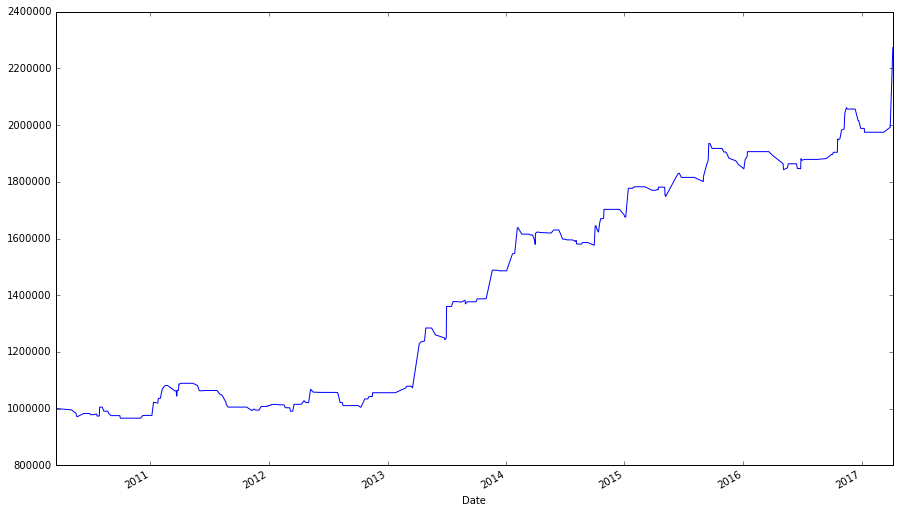

In [36]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

In [37]:
spyder = web.DataReader("SPY", "yahoo", start, end)
spyder.iloc[[0,-1],:]

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,118944600,97.788948
2017-04-07,235.149994,236.000000,234.639999,235.199997,69005100,235.199997


In [38]:
batches = 1000000 // np.ceil(100 * spyder.ix[0,"Adj Close"]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder.ix[0,"Adj Close"] # How much money is used to buy SPY
final_val = batches * batch * spyder.ix[-1,"Adj Close"] + (1000000 - trade_val) # Final value of the portfolio
final_val

2401592.6998000005

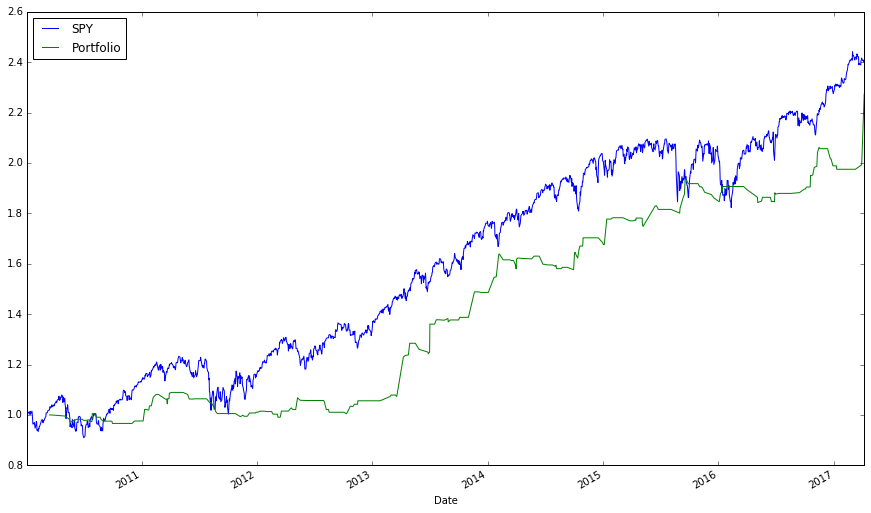

In [39]:
# We see that the buy-and-hold strategy beats the strategy we developed earlier. I would also like to see a plot.
ax_bench = (spyder["Adj Close"] / spyder.ix[0, "Adj Close"]).plot(label = "SPY")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 1000000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench